In [1]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#For data import
import glob
import os

#For datetime 
import datetime


In [32]:
'''PROBE DATA IMPORT'''
#Soil Data from Gropoint sensors
directory = './Raw Data/GroPoint/'
save_path = '../Figures/soilPlots/'
import_path_frost = "./Raw Data/"
all_files = glob.glob(os.path.join(directory, 'S*.txt'))
bog_files = glob.glob(os.path.join(directory, 'S*.csv'))

allSoil = []
for filename in all_files:
    df = pd.read_csv(filename, 
                    sep = ',',
                    header = None, 
                    names = ['DateTime', 'SensorAddress',
                            'SoilMoist_15cm', 'SoilMoist_30cm', 'SoilMoist_45cm', 
                            'SoilTemp1', 'SoilTemp2', 'SoilTemp3', 'SoilTemp4', 'SoilTemp5', 'SoilTemp6'])
        
    df['SensorName'] = filename[-16:-12]
    df['Watershed'] = filename[-16:-14]

    allSoil.append(df)

allSoil = pd.concat(allSoil, ignore_index=True)

#Precipitation data - update from MN DNR site occasionally, eventually replace with MEF data
precip_directory = './Raw Data/'
precip = pd.read_csv(precip_directory + 'GrandRapids_Precip_MNDNR.csv', 
                     na_values = ['T', 'M'], 
                     parse_dates = ['Date'], 
                     names = ['Date', 'Tmax_F', 'Tmin_F', 'P_in', 'Snow_in', 'SnowDepth_in'], 
                     header = 0, 
                     dtype = {'P_in':float, 'Snow_in':float, 'SnowDepth_in':float})

#Import S2 Forest Met Station Data
met_directory = './Cleaned Data/ATM/'
S2Fmet = pd.read_csv(met_directory + '01_CleanedS2F.csv', 
                    parse_dates = ['TIMESTAMP'])

#For timestamp rounding
dt_format = "%Y-%m-%d %H:%M"

#Import historical soil moisture data
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/612/2/9769461f3732c922a9af819587922c86".strip() 
infile1  = infile1.replace("https://","http://")
                 
histSoil = pd.read_csv(infile1, skiprows = 1, sep = ",",
        names = ["DATE", "LOCATION", "d_15", "d_46", "d_76", "d_107", "d_137", "d_168",     
                    "d_198", "d_229", "d_259", "d_290", "d_320"],
        parse_dates = ['DATE',])

In [ ]:
'''FUNCTIONS'''

def roundTime(dt=None, roundTo=60):
   """Round a datetime object to any time lapse in seconds
   dt : datetime.datetime object, default now.
   roundTo : Closest number of seconds to round to, default 1 minute.
   Author: Thierry Husson 2012 - Use it as you want but don't blame me.
   """
   if dt == None : dt = datetime.datetime.now()
   seconds = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

def plotMoisture(df, P, met, save_path):
    fig, ax1 = plt.subplots(1, 1, 
                        figsize=(6, 3),
                        layout="constrained")
    
    #Soil Moisture
    ax1.plot(df.DateTime, df.SoilMoist_15cm, '-r',
     label = '15cm')
    ax1.plot(df.DateTime, df.SoilMoist_30cm, '-b',
     label = '30cm')
    ax1.plot(df.DateTime, df.SoilMoist_45cm, '-g',
     label = '45cm')
    ax1.set_ylabel("Soil Moisture, VMC [cm3/cm3]")

    ax12 = ax1.twinx()
    Psnip = snipPrecip(P, min(df.DateTime), max(df.DateTime)) 
    ax12.bar(Psnip.Date, Psnip.P_in, color = 'silver', zorder = -2)  
    ax12.set_ylabel("S2 Forest Precipition [in]")  

    plt.xlabel("Date")
    plt.title(str(df.SensorName[0]))

    plt.xlim(min(df.DateTime), max(df.DateTime))

    ax1.legend()

    #plt.show()
    plt.savefig(save_path + "moistfig" + str(df.SensorName[0]) + ".pdf")
    plt.savefig(save_path + "moistfig" + str(df.SensorName[0]) + ".jpg")

    plt.show()

def plotTemp(df, P, met, save_path):
    fig, ax1 = plt.subplots(1, 1, 
                        figsize=(6, 3),
                        sharex=True,
                        layout="constrained")
    

    #Soil Temperature
    ax1.plot(df.DateTime, df.SoilTemp1,
     label = '5cm')
    ax1.plot(df.DateTime, df.SoilTemp2,
     label = '15cm')
    ax1.plot(df.DateTime, df.SoilTemp3, 
     label = '25cm')
    ax1.plot(df.DateTime, df.SoilTemp4, 
     label = '35cm')
    ax1.plot(df.DateTime, df.SoilTemp5, 
     label = '45cm')
    ax1.plot(df.DateTime, df.SoilTemp6, 
     label = '55cm')
    ax1.set_ylabel("Soil Temperature")

    ax12 = ax1.twinx()
    Psnip = snipPrecip(P, min(df.DateTime), max(df.DateTime)) 
    ax12.bar(Psnip.Date, Psnip.P_in, color = 'silver', zorder = -2)  
    ax12.set_ylabel("S2 Forest Precipition [in]")  

    plt.xlabel("Date")
    plt.title(str(df.SensorName[0]))

    plt.xlim(min(df.DateTime), max(df.DateTime))

    ax1.patch.set_visible(False)

    ax1.legend()

    #plt.show()
    plt.savefig(save_path + "tempfig" + str(df.SensorName[0]) + ".pdf")
    plt.savefig(save_path + "tempfig" + str(df.SensorName[0]) + ".jpg")

    plt.show()

def snipPrecip(P, fir, la):
    #function trims the precip log to the specified dates, filling in NaNs where there is no available data
    #P must be a timeseries containing at least two columns, one with dates and one with precip values
    range = pd.date_range(start = fir.date(), end = la.date())
    return P.set_index('Date').reindex(range).rename_axis('Date').reset_index()
   
def snipTemp(met, fir, la):
    #function trims the precip log to the specified dates, filling in NaNs where there is no available data
    #P must be a timeseries containing at least two columns, one with dates and one with precip values
    print(fir)
    print(la)
    range = pd.date_range(start = fir, end = la, freq = '30min')
    return met.set_index('TIMESTAMP').reindex(range).rename_axis('TIMESTAMP').reset_index()
   
def clipTo(df, date):
    #Remove data before a certain date as the sensor is stabilizing
    #def is a gropoint sensor datafile
    #date is the date to clip to
    return df[df.DateTime > pd.to_datetime(date)].reset_index()

def patch_breakpoints(signal, name, depth, breakpt_dict):
    # patch spikes before & after -- assume that after is offset to match exactly before
    signal_offset = signal.copy() # replicating water table series
    ibefore = breakpt_dict[name][depth]['ibefore']
    iafter = breakpt_dict[name][depth]['iafter']
    fill_option= breakpt_dict[name][depth]['fill_opt']
    # include an option to just keep water table where it is at the end of the recovery & only interpolate the breakpoint
       
    # automatically iterate over spikes to calculate offset and fix
    if len(fill_option) == 0: 
        fill_option = len(ibefore)*[0] # this defaults to interpolating
        
    for i, (ibef, iaft) in enumerate(zip(ibefore, iafter)):
        
        # linearly interpolate between before and after
        if fill_option[i] == 0: 
            iinterp = np.arange(ibef, iaft+1)
            xp = [ibef, iaft]
            fp = [signal_offset[ibef], signal_offset[iaft]]
            signal_offset[iinterp] = np.interp(iinterp, xp, fp)
            
        # patch before and after by calculating offset 
        if fill_option[i] == 1:    
            offset = signal[iaft] - signal[ibef]
            signal_offset[ibef:iaft] = signal_offset[ibef]
            signal_offset[iaft:] = signal_offset[iaft:] - offset

        # just return NaNs
        if fill_option[i] == 2:
            signal_offset[ibef:iaft] = np.nan

    return signal_offset



<AxesSubplot:xlabel='d_15', ylabel='Density'>

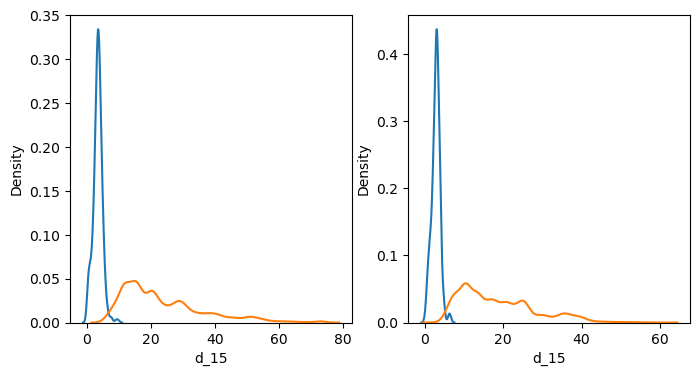

In [44]:
'''Compare Current Data Range with Historical Data'''
S2histSoil = histSoil[histSoil.LOCATION.isin(['S2E', 'S2S', 'S2W'])]
S6histSoil = histSoil[histSoil.LOCATION.isin(['S6', 'S6N', 'S6S'])]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (8, 4))

#S2
#Ballpark PAW using bar data from historical records
sns.kdeplot(data = S2histSoil, x = 'd_15', ax = ax1)
sns.kdeplot(data = allSoil[allSoil.Watershed == 'S2'], x = 'SoilMoist_15cm', ax = ax1)

#S6
sns.kdeplot(data = S6histSoil, x = 'd_15', ax = ax2)
sns.kdeplot(data = allSoil[allSoil.Watershed == 'S6'], x = 'SoilMoist_15cm', ax = ax2)

In [ ]:
'''Select a site'''

'''Patch Data'''
from breakpts import moistpt_dict

#Process:
# 1 - Select site 
# 2 - Plot site data
# 3 - Select data vector for cleaning by column name
# 4 - Add values to the breakpoints dictionary
# 5 - Gapfill 
# 6 - Replace in dataframe
# 7 - Plot again
# 8 - Concat

###############################
#For compiling cleaned data
cleanedFile_list = []

#1 - Select site
for site in ['S205', 'S215', 'S244', 'S254', 'S603', 'S613', 'S622', 'S632']:
    file = np.extract([site in a for a in all_files], all_files)[0]

    #2 - Import and plot site data
    df = pd.read_csv(file, 
                    sep = ',',
                    header = None, 
                    names = ['DateTime', 'SensorAddress',
                            'SoilMoist_15cm', 'SoilMoist_30cm', 'SoilMoist_45cm', 
                            'SoilTemp1', 'SoilTemp2', 'SoilTemp3', 'SoilTemp4', 'SoilTemp5', 'SoilTemp6'])
        
    df['SensorName'] = site
    
    for i in range(0, len(df['DateTime'])):
        #Converts to datetime format
        df.DateTime[i] = datetime.datetime.strptime(df.DateTime[i], dt_format)
        #Rounds to the nearest hour
        df.DateTime[i] = roundTime(df.DateTime[i], roundTo = 60*60)

    #Remove first month of data -- sensor stabilization
    df = clipTo(df, '2022-12-01')
    df = df.reset_index()
        
    #Plot soil moisture
    plotMoisture(df, precip, S2Fmet, save_path)

    #Plot soil temperature
    #plotTemp(df, precip, S2Fmet, save_path)

    ###################################
    # Pause to add values to dictionary
    ###################################


    #Make a copy for saving cleaned data
    df_clean = df

    #3 - Select data vector for cleaning
    for cleaning in ['SoilMoist_15cm', 'SoilMoist_30cm', 'SoilMoist_45cm']:
        cleanVec = df[cleaning]

        #5 - Gapfill
        logger_offset = patch_breakpoints(cleanVec.values, site, cleaning, moistpt_dict)

        #3.5 - Plot individual data
        fig, ax = plt.subplots(1, 1, figsize = (6, 3))
        ax.plot(cleanVec, label = 'Before')
        ax.plot(logger_offset, label = 'After')
        ax.set_xlim(min(cleanVec.index), max(cleanVec.index))
        ax.set_title(site + ', ' + cleaning)

        #6 - Save back to dataframe
        df_clean[cleaning] = logger_offset

    #7 - Replot
    plotMoisture(df_clean, precip, S2Fmet, save_path)

    #8 - Concat
    cleanedFile_list.append(df_clean)



In [ ]:
'''Concatenate all data together and export'''
sensor_data = pd.concat(cleanedFile_list, axis = 0, ignore_index = True)

In [ ]:

'''
#Plots - Bog
### Bog sensors
bog_file_list = []
for file in bog_files:
    df = pd.read_csv(file, 
                     sep = ',', 
                     header = 1, 
                     names = ['DateTime', 'WaterTemp_C',
                              'Host Connected', 'End of File'], 
                     parse_dates = ['DateTime'])
    
    df['SensorName'] = file[file.find('\S')+1:file.find('\S')+5]
    df['SensorDepth_cm'] = file[file.find('\S')+6:file.find('\S')+8]

    
    #for i in range(0, len(df['DateTime'])):
    #    #Converts to datetime format
    #   df.DateTime[i] = datetime.datetime.strptime(df.DateTime[i], dt_format)
    #    #Rounds to the nearest hour
    #    df.DateTime[i] = roundTime(df.DateTime[i], roundTo = 60*60)

    bog_file_list.append(df)

#Concatenate all files in list
bog_sensor_data = pd.concat(bog_file_list, axis = 0, ignore_index = True)

#Plot bog data
for site in set(bog_sensor_data.SensorName):
    data = bog_sensor_data[bog_sensor_data.SensorName == site].reset_index(drop = True)

    fig, ax = plt.subplots(figsize=(6, 4),
                    layout="constrained")
    
    #Precip
    #ax2 = ax.twinx()
    #Psnip = snipPrecip(precip, min(df.DateTime), max(df.DateTime))
    #ax2.bar(Psnip.Date, Psnip.P_in, color = 'lightgrey')

    #ax2.set_ylabel("Precipitation [in]")

    #Soil Temperature
    for depth in set(data.SensorDepth_cm):
        plt.plot(data[data.SensorDepth_cm == depth].DateTime, data[data.SensorDepth_cm == depth].WaterTemp_C, label = str(depth) + 'cm')
    
    ax.set_ylabel("Water Temperature [C]")

    plt.xlabel("Date")
    plt.title(str(data.SensorName[0]))

    plt.xlim(min(data.DateTime), max(data.DateTime))

    #ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)

    ax.legend()

    #plt.show()
    plt.savefig(save_path + "tempfig" + str(data.SensorName[0]) + "_" + str(df.SensorDepth_cm[0]) + ".pdf")
    plt.savefig(save_path + "tempfig" + str(data.SensorName[0]) + "_" + str(df.SensorDepth_cm[0]) + ".jpg")

    plt.show()

#%%
#EXPORT CSV FILE
sensor_data.to_csv('./Cleaned Data/01_cleanedsensordata.csv')
''' 